In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={"figure.figsize": (16, 8)})
import plotly.express as px
import scipy.stats as ss
from statsmodels. stats.multicomp import pairwise_tukeyhsd
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.stats import chi2_contingency, chi2, mannwhitneyu, shapiro, kruskal
import statsmodels.api as sa 
import scikit_posthocs as sp  # sp.posthoc_dunn() для непараметрического аналога anova 

## Считываем и изучаем данные.

In [2]:
df_1 = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-c/Statistics/AB_test_practice/ab_users_data.csv')
df_2 = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-c/Statistics/AB_test_practice/ab_orders.csv')
df_3 = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-c/Statistics/AB_test_practice/ab_products.csv')

In [3]:
df_1.head()

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1


In [4]:
df_1.shape

(4337, 6)

In [5]:
df_1.isna().sum()

user_id     0
order_id    0
action      0
time        0
date        0
group       0
dtype: int64

In [6]:
df_1.dtypes

user_id      int64
order_id     int64
action      object
time        object
date        object
group        int64
dtype: object

In [7]:
df_2.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56.000000,"{74, 6}"
4,1259,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"


In [8]:
df_2.shape

(4123, 3)

In [9]:
df_2.isna().sum()

order_id         0
creation_time    0
product_ids      0
dtype: int64

In [10]:
df_2.dtypes

order_id          int64
creation_time    object
product_ids      object
dtype: object

In [11]:
df_3.head()

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4
3,4,леденцы,45.5
4,5,кофе 3 в 1,15.0


In [12]:
df_3.shape

(87, 3)

In [13]:
df_3.isna().sum()

product_id    0
name          0
price         0
dtype: int64

In [14]:
df_3.dtypes

product_id      int64
name           object
price         float64
dtype: object

### Обозачим метрики. Целевая метрика - выручка на пользователя. Прокси метрики - количество товаров в заказе, стоимость заказа, количество заказов на пользователя.
### H0 - Значeния метрик у контрольной и тестовой группы не изменились, H1 - значения метрик изменились.

### 1) Количество товаров в заказе.

In [15]:
# Объедиим df_1 и df_2. Оставим только заказы в статусе create_order. Убираем колонки с датами. Они пока не нужны для анализа. 
# Action тоже убираем. Осталось только создание заказа.

In [16]:
df_4 = df_1[df_1['action']=="create_order"].merge(df_2, on='order_id').drop(['action', 'time', 'creation_time', 'date'], axis=1)

In [17]:
df_4.head()

,user_id,order_id,group,product_ids
0,964,1255,0,"{75, 22, 53, 84}"
1,965,1256,1,"{56, 76, 39}"
2,964,1257,0,"{76, 34, 41, 38}"
3,966,1258,0,"{74, 6}"
4,967,1259,1,"{20, 45, 67, 26}"


In [18]:
# Создадим столбец с количеством товаров.

In [19]:
df_4['products_number'] = df_4.product_ids.apply(lambda x: len(x.split()))

In [20]:
df_4.head()

,user_id,order_id,group,product_ids,products_number
0,964,1255,0,"{75, 22, 53, 84}",4
1,965,1256,1,"{56, 76, 39}",3
2,964,1257,0,"{76, 34, 41, 38}",4
3,966,1258,0,"{74, 6}",2
4,967,1259,1,"{20, 45, 67, 26}",4


In [21]:
# Сформируем 2 выборки. Поскольку количество заказов - дискретная переменная, применяем хи-квадрат.

In [22]:
df_4_1= df_4[df_4['group']==0]
df_4_2= df_4[df_4['group']==1]

In [23]:
df_4_1.products_number.value_counts(normalize=True).mul(100)

3    31.696706
4    23.679304
2    20.882536
5    12.492231
1     5.531386
6     4.661280
7     0.994406
8     0.062150
Name: products_number, dtype: float64

In [24]:
df_4_2.products_number.value_counts(normalize=True).mul(100)

3    28.957836
4    24.343675
2    21.360382
5    13.603819
1     6.165473
6     4.733492
7     0.676213
8     0.159109
Name: products_number, dtype: float64

In [25]:
pd.crosstab(df_4.group, df_4.products_number)

products_number,1,2,3,4,5,6,7,8
group,,,,,,,,
0,89,336,510,381,201,75,16,1
1,155,537,728,612,342,119,17,4


In [26]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df_4.group, df_4.products_number))
stat, p

(6.33608168847106, 0.5010999570917679)

In [27]:
prob = 0.95
alpha = 1 - 0.95
p = 0.5010999570917679
if p <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Не отклоняем H0


### Вывод: различия в  метрике не статистически значимые. Нулевую гипотезу не отклоняем.

### 2) Стоимость товаров в заказе.

In [28]:
# Создаем df_6 с 2 колонками order_id и products_id. Далее выделеяем каждый id товара в отдельную строку.

In [29]:
df_6 = df_4[['order_id', 'product_ids']]
df_6.head()

,order_id,product_ids
0,1255,"{75, 22, 53, 84}"
1,1256,"{56, 76, 39}"
2,1257,"{76, 34, 41, 38}"
3,1258,"{74, 6}"
4,1259,"{20, 45, 67, 26}"


In [30]:
df_6.product_ids = df_6.product_ids.apply(lambda x: x.strip("{}").split(","))

/opt/tljh/user/lib/python3.7/site-packages/pandas/core/generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [31]:
df_6 = df_6.explode('product_ids').rename(columns={'product_ids': 'product_id'})
df_6.head()

,order_id,product_id
0,1255,75
0,1255,22
0,1255,53
0,1255,84
1,1256,56


In [32]:
df_6.dtypes

order_id       int64
product_id    object
dtype: object

In [33]:
df_6 = df_6.astype({'product_id': 'int64'})

In [34]:
df_6.dtypes

order_id      int64
product_id    int64
dtype: object

In [35]:
df_6.head()

,order_id,product_id
0,1255,75
0,1255,22
0,1255,53
0,1255,84
1,1256,56


In [36]:
df_6.shape

(13826, 2)

In [37]:
# Объедияем информацию по заказу с ценой каждого товара по product_id.

In [38]:
df_7 = df_6.merge(df_3, on='product_id')

In [39]:
# Считаем стоимость каждого заказа.

In [40]:
df_8 = df_7.groupby('order_id', as_index=False).agg({'price': 'sum'})

In [41]:
df_8.head()

,order_id,price
0,1255,408.7
1,1256,250.5
2,1257,310.2
3,1258,85.0
4,1259,228.0


In [42]:
# Объединяем по order_id получившийся датафрейм с датафреймом df_4 с разделением на группы.

In [43]:
df_9 = df_8.merge(df_4, on='order_id')

In [44]:
df_9.head()

,order_id,price,user_id,group,product_ids,products_number
0,1255,408.7,964,0,"{75, 22, 53, 84}",4
1,1256,250.5,965,1,"{56, 76, 39}",3
2,1257,310.2,964,0,"{76, 34, 41, 38}",4
3,1258,85.0,966,0,"{74, 6}",2
4,1259,228.0,967,1,"{20, 45, 67, 26}",4


In [45]:
# Формируем отдельные датасеты для контрольной и тестовой группы.

In [46]:
df_9_1= df_9[df_9['group']==0]
df_9_2= df_9[df_9['group']==1]

In [47]:
# Данные непрерывные, построим гистрограммы и проверим на нормалность.

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


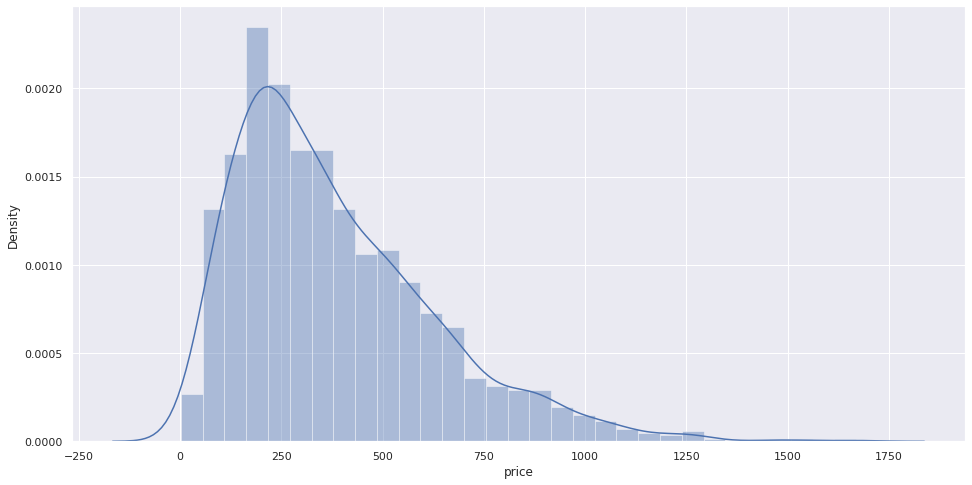

In [48]:
sns.distplot(df_9_1.price)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


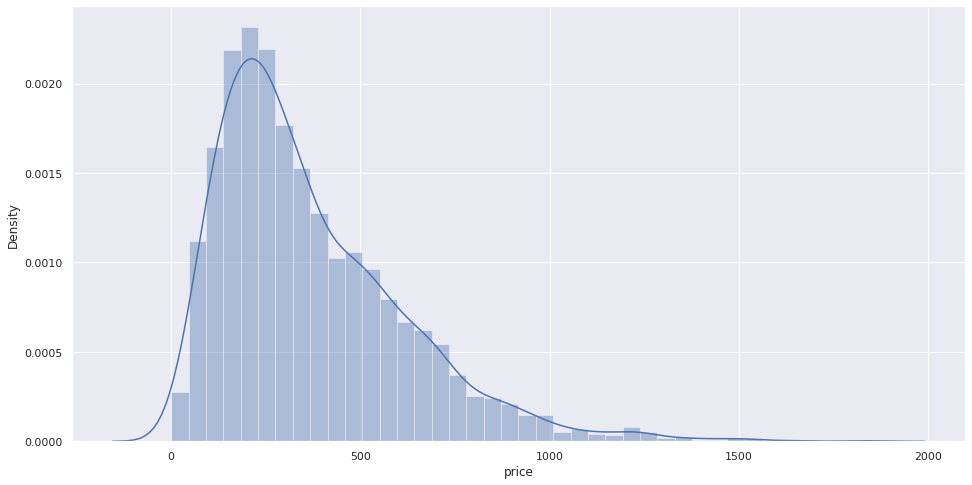

In [49]:
sns.distplot(df_9_2.price)

In [50]:
ss.normaltest(df_9_1.price)

NormaltestResult(statistic=288.6208180681972, pvalue=2.122196897492167e-63)

In [51]:
ss.normaltest(df_9_2.price)

NormaltestResult(statistic=597.6831916887269, pvalue=1.6396228483368307e-130)

In [52]:
# Отклоняем нулевую гипоезу о нормальности данных.

In [53]:
# Попробуем пролагарфмировать данные.

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


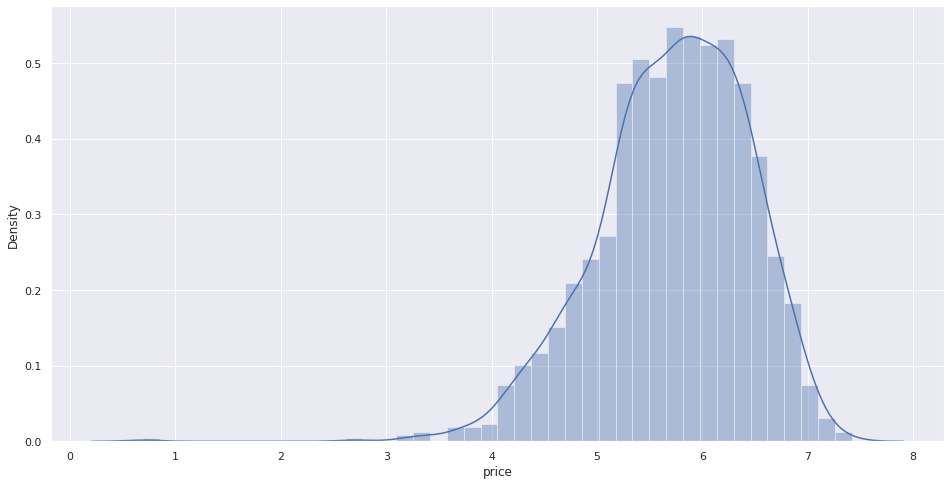

In [54]:
sns.distplot(np.log(df_9_1.price))

In [55]:
ss.normaltest(np.log(df_9_1.price))

NormaltestResult(statistic=158.21343226740055, pvalue=4.409503601439522e-35)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


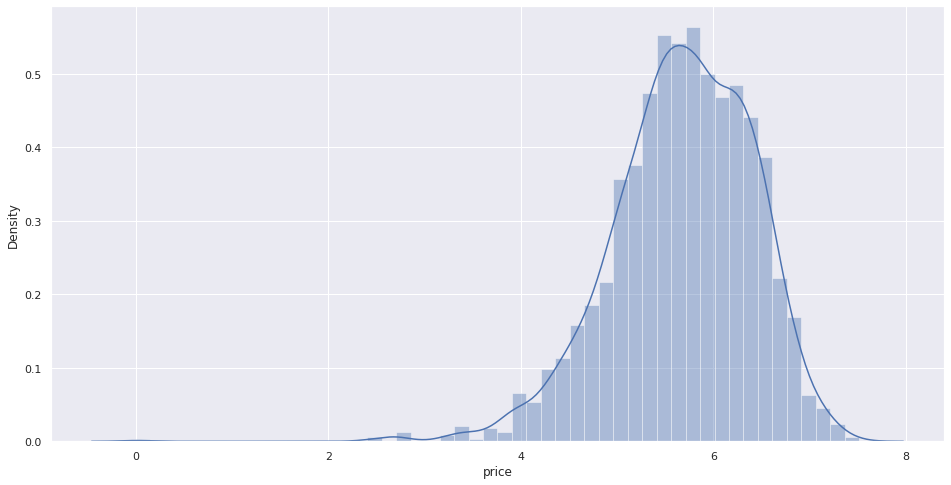

In [56]:
sns.distplot(np.log(df_9_2.price))

In [57]:
ss.normaltest(np.log(df_9_2.price))

NormaltestResult(statistic=292.7899472419741, pvalue=2.6391907356315118e-64)

In [58]:
# Все равно распределение ненормальное.
# Применяем критерий Манна Уитни.

In [59]:
ss.mannwhitneyu(df_9_1.price, df_9_2.price)

MannwhitneyuResult(statistic=2089847.0, pvalue=0.07092841734481316)

In [60]:
prob = 0.95
alpha = 1 - 0.95
p = 0.07092841734481316
if p <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Не отклоняем H0


### Вывод: различия в  метрике не статистически значимые. Нулевую гипотезу не отклоняем.

### 3) Количество товаров на пользователя.

In [61]:
# Объединяем df_6 c df_4 по order_id.

In [62]:
df_10 = df_6.merge(df_4, on='order_id')

In [63]:
#Группируем по user_id с сохранением значения группы.

In [64]:
df_11 = df_10.groupby(['user_id', 'group'], as_index=False).agg({'product_id': 'count'})
df_11.head()

,user_id,group,product_id
0,964,0,8
1,965,1,33
2,966,0,2
3,967,1,18
4,968,0,11


In [65]:
# Поскольку количество товаров - дискретная переменная, применяем хи-квадрат.

In [66]:
df_11_1= df_11[df_11['group']==0]
df_11_2= df_11[df_11['group']==1]

In [67]:
pd.crosstab(df_11.group, df_11.product_id)

product_id,1,2,3,4,5,6,7,8,9,10,...,33,34,35,36,38,40,41,43,44,49
group,,,,,,,,,,,,,,,,,,,,,
0,7,21,29,26,32,41,34,33,46,41,...,0,0,0,1,1,0,0,1,0,0
1,1,7,4,15,9,15,12,7,10,16,...,7,2,2,0,1,2,1,1,1,1


In [68]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df_11.group, df_11.product_id))
stat, p

(239.82447685504263, 6.367608520593747e-30)

In [69]:
prob = 0.95
alpha = 1 - 0.95
p = 6.367608520593747e-30
if p <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Отклоняем H0


### Вывод: различия в  метрике статистически значимые. Нулевую гипотезу отклоняем.

### 4) Выручка на пользователя.

In [70]:
#Объедияем таблицу с пользователями и группами с таблицей со стоимостью заказов по order_id.

In [71]:
df_12 = df_8.merge(df_4, on='order_id')
df_12.head()

,order_id,price,user_id,group,product_ids,products_number
0,1255,408.7,964,0,"{75, 22, 53, 84}",4
1,1256,250.5,965,1,"{56, 76, 39}",3
2,1257,310.2,964,0,"{76, 34, 41, 38}",4
3,1258,85.0,966,0,"{74, 6}",2
4,1259,228.0,967,1,"{20, 45, 67, 26}",4


In [72]:
#Группируем по uder_id и группе и считаем сумму на пользователя.

In [73]:
df_13 = df_12.groupby(['user_id', 'group'], as_index=False).agg({'price': 'sum'})
df_13.head()

,user_id,group,price
0,964,0,718.9
1,965,1,4155.5
2,966,0,85.0
3,967,1,1137.4
4,968,0,1590.7


In [74]:
# Формируем отдельные датасеты для контрольной и тестовой группы.

In [75]:
df_13_1= df_13[df_13['group']==0]
df_13_2= df_13[df_13['group']==1]

In [76]:
# Данные непрерывные, построим гистрограммы и проверим на нормалность.

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


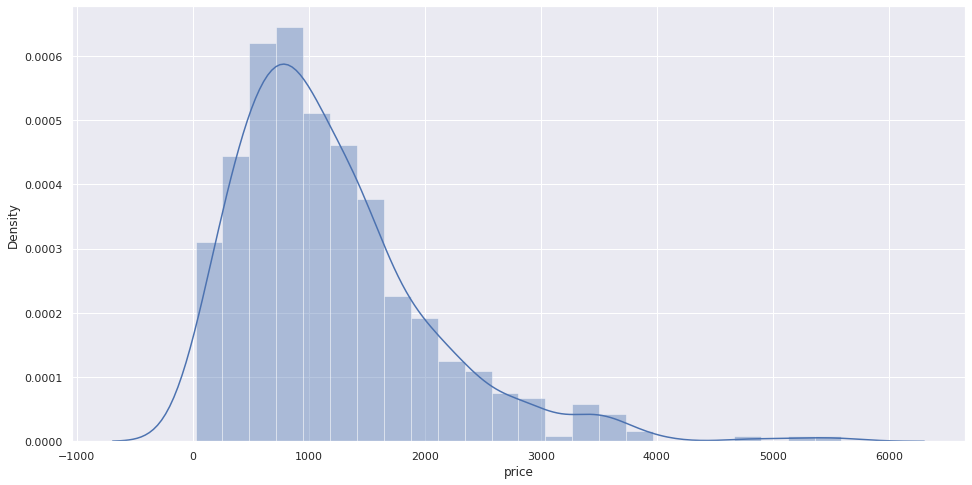

In [77]:
sns.distplot(df_13_1.price)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


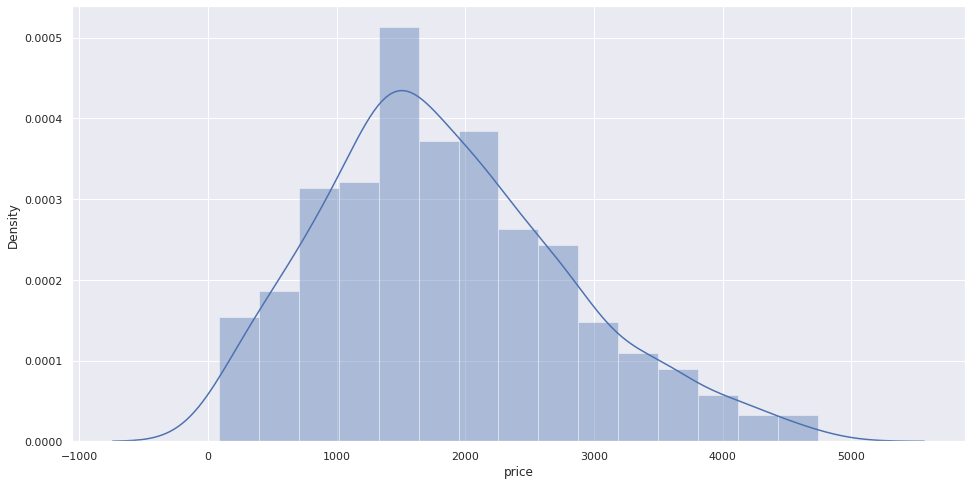

In [78]:
sns.distplot(df_13_2.price)

In [79]:
ss.normaltest(df_13_1.price)

NormaltestResult(statistic=158.04270445102435, pvalue=4.8024491591736294e-35)

In [80]:
ss.normaltest(df_13_2.price)

NormaltestResult(statistic=21.921081107450178, pvalue=1.73739160560097e-05)

In [81]:
# Отклоняем нулевую гипоезу о нормальности данных.

In [82]:
# Попробуем пролагарфмировать данные.

In [83]:
ss.normaltest(np.log(df_13_1.price))

NormaltestResult(statistic=70.34242927061122, pvalue=5.31294796011223e-16)

In [84]:
ss.normaltest(np.log(df_13_2.price))

NormaltestResult(statistic=129.6646476613344, pvalue=6.977173319226162e-29)

In [85]:
# Все равно распределение ненормальное.
# Применяем критерий Манна Уитни.

In [86]:
ss.mannwhitneyu(df_13_1.price, df_13_2.price)

MannwhitneyuResult(statistic=73198.5, pvalue=4.991032611140459e-33)

In [87]:
prob = 0.95
alpha = 1 - 0.95
p = 4.991032611140459e-33
if p <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Отклоняем H0


### Вывод: различия в  метрике статистически значимые. Нулевую гипотезу отклоняем.

## Вывод: в рамках заказов мы не отклонили нулевую гипотезу о равенстве 2 групп, однако в разрезе пользователей удалось показать статистически значимые различия. Т.е. в целом пользователи из тестовой группы стали заказывать больше товаров и тратить больше. Т.о. принимаем решение распространить новую систему рекомендаций на всех пользователей.